In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import polars as pl

lambda_arrival = 4
lambda_service = 100
num_events = 5000

interarrival_times = [0.0] + np.random.exponential(scale=1/lambda_arrival, size=num_events - 1).tolist()
work_times = np.random.exponential(scale=1/lambda_service, size=num_events).tolist()

arrival_times = np.cumsum(interarrival_times).tolist()

print(f"Arrival Times: {arrival_times}")

served_times = []
finish_times = []

busy_until = -1.0
for arrival, work_time in zip(arrival_times, work_times):
    served_time = max(arrival, busy_until)
    busy_until = served_time + work_time
    served_times.append(served_time)
    finish_times.append(busy_until)

print(f"Time service begins: {served_times}")
print(f"Time finish works: {finish_times}")
print(f"Busy until: {busy_until}")

current_time = 0
num_customer_serving = []
num_customer_waiting = []
num_customer_sys = []
time_step=0.1
num_samples = int(busy_until/time_step)
print(f"Sample {num_samples} times")

for _ in range(num_samples):
    serving = sum(served_time <= current_time < served_time + work for (served_time, work) in zip(served_times, work_times))
    waiting = sum(arrival <= current_time < served_time for (arrival, served_time) in zip(arrival_times, served_times))
    
    num_customer_serving.append(serving)
    num_customer_waiting.append(waiting)
    num_customer_sys.append(serving + waiting)

    current_time += time_step

In [ ]:
times_wait_queue = [s_time - a_time for s_time, a_time in zip(served_times, arrival_times)]
times_in_sys = [q_t + (f_t - s_t) for q_t, f_t, s_t in zip(times_wait_queue, finish_times, served_times)]
idle_times = [served_times[i] - finish_times[i-1] for i in range(len(served_times)) if i!=0]

average_wait_queue = sum(times_wait_queue)/num_events
average_service_time = sum(work_times)/num_events
average_time_interarr = sum(interarrival_times)/(num_events - 1)
average_wait_per_wait = sum(times_wait_queue)/sum(num_customer_waiting)
average_sys_time = sum(times_in_sys)/num_events
p_wait = sum(num_customer_waiting)/num_events
p_idle = sum(idle_times)/num_samples

p_idle

In [ ]:
class MG1:
    def __init__(self, seq):
        self.seq = seq

    @property
    def seq(self):
        return self._seq
    
    @property
    def graph(self):
        def round_markov_graph(graph, decimals=2):
            factor = 10 ** decimals
            new_graph = {}

            for node, transitions in graph.items():
                rounded_transitions = {k: round(v * factor) for k, v in transitions.items()}
                total = sum(rounded_transitions.values())
                diff = factor - total

                if diff != 0:
                    max_key = max(rounded_transitions, key=rounded_transitions.get)
                    rounded_transitions[max_key] += diff

                final_transitions = {k: v / factor for k, v in rounded_transitions.items() if v > 0}

                if final_transitions:
                    new_graph[node] = final_transitions
            return new_graph

        return round_markov_graph(self._graph)
    
    @seq.setter
    def seq(self, new_seq):
        if not isinstance(new_seq, (list, str)):
            raise ValueError("Sequence must be a list or string.")
        if len(new_seq) < 2:
            raise ValueError("Sequence must have at least 2 elements.")
        self._seq = new_seq
        self._graph = self.__fit()
        self._vocab = sorted(set(self._seq))
    
    def __fit(self):
        dict_seq = {}
        def process_seq(seq):
            for state in seq:
                dict_seq[state] = {}
            for i in range(len(seq) -1):
                if seq[i+1] not in dict_seq[seq[i]]:
                    dict_seq[seq[i]][seq[i+1]] = 1
                else:
                    dict_seq[seq[i]][seq[i+1]] += 1
            return dict_seq
        def cal_markov(dict_seq):
            for key in dict_seq:
                total = sum(dict_seq[key].values())
                for key2 in dict_seq[key]:
                    dict_seq[key][key2] /= total
            return dict_seq
        
        return cal_markov(process_seq(self._seq))
    
    def draw(self, fgsz=10, layout='spring'):
        from netgraph import Graph

        G = nx.DiGraph()
        for start_node, value in self.graph.items():
            for end_node, weight in value.items():
                G.add_edge(start_node, end_node, label=weight)

        if layout == 'spring':
            pos = nx.spring_layout(G, k=1.2)
        elif layout == 'kamada':
            pos = nx.kamada_kawai_layout(G)
        elif layout == 'circular':
            pos = nx.circular_layout(G)
        else:
            raise ValueError("Layout must be 'spring', 'kamada', or 'circular'")

        plt.figure(figsize=(fgsz, fgsz))     
        edge_labels = nx.get_edge_attributes(G, 'label')
        nx.draw(G, pos = pos, connectionstyle="arc3,rad=0.1", with_labels=True)

        plt.title("Markov Transition Graph", fontsize=14 * (fgsz / 10))
        plt.show()
    
    @property
    def trans_matrix(self):
        data = [(src, dst, prob) for src, trans in self.graph.items() for dst, prob in trans.items()]
        df = pl.DataFrame(data, schema=["state_from", "state_to", "prob"], orient="row")
        return df.pivot(values="prob", index="state_to", on="state_from", aggregate_function="first").fill_null(0)
    
mg = MG1(num_customer_sys)
mg.draw(15)

In [ ]:
time_points = np.arange(0, num_samples * time_step, time_step)

plt.figure(figsize=(10, 5))
plt.plot(time_points, num_customer_serving, label="Serving", color='g')
plt.plot(time_points, num_customer_waiting, label="Waiting", color='r')
plt.plot(time_points, num_customer_sys, label="Total in System", color='b')
plt.xlabel("Time")
plt.ylabel("Customer")
plt.title("Number of customer over time")
plt.legend()
plt.grid()
plt.show()

In [ ]:
import numpy as np
import heapq
from typing import List, Optional
from dataclasses import dataclass

num_arrival_stages = 2
num_service_stages = 2
num_servers_c = 2
buffer_length = 30

lda = 1/10
rho = 1.05

@dataclass
class Event:
    time: float
    event_type: str
    server_id: Optional[int] = None

    def __lt__(self, other):
        return self.time < other.time


@dataclass
class SimulationConfiguration:
    lambda_arrival: float
    mu_service: float
    num_arrival_stages: int
    num_service_stages: int
    num_servers_c: int
    C: int
    K: int

    @property
    def rho(self):
        return self.lambda_arrival / (self.C * self.mu_service)


class QueueSimulator:
    def __init__(self, configuration: SimulationConfiguration):
        self.event_queue : List[Event] = []
        self.C = configuration.C
        self.K = configuration.K

        self.lambda_arrival = configuration.lambda_arrival
        self.mu_service = configuration.mu_service

        self.num_arrival_stages = configuration.num_arrival_stages
        self.num_service_stages = configuration.num_service_stages

        self.event_queue: List[Event] = []
        self.num_arrivals = 0
        self.num_losses = 0
        self.total_customers = 0
        self.event_counter = 0

        self.servers_state = np.zeros(self.C)

        self.clk = 0

        self.acceptable_event_types = ['A' + str(i) for i in range(1, self.num_arrival_stages + 1)] + \
            ['S' + str(i) for i in range(1, self.num_service_stages + 1)]

    def schedule_event(self, event: Event):
        heapq.heappush(self.event_queue, event)

    def get_next_event(self) -> Event:
        return heapq.heappop(self.event_queue)

    def rand_exp_arrival(self):
        return np.random.exponential(1/(self.num_arrival_stages * self.lambda_arrival))

    def rand_exp_service(self):
        return np.random.exponential(1/(self.num_service_stages * self.mu_service))

    def handle_event(self, event: Event):
        def handle_a1_event():
            next_event = Event(time=event.time + self.rand_exp_arrival(), event_type='A2')
            self.schedule_event(next_event)

        def handle_a2_event():
            self.num_arrivals += 1
            if self.total_customers < self.K:
                self.total_customers += 1
                mask_server_state = self.servers_state == 0
                if np.any(mask_server_state):
                    server_id = np.argmin(mask_server_state)
                    next_event = Event(time=event.time + self.rand_exp_service(), event_type='S1', server_id=server_id)
                    self.schedule_event(next_event)
                    self.servers_state[server_id] = 1
            else:
                self.num_losses += 1

        def handle_s1_event():
            server_id = event.server_id
            self.servers_state[server_id] = 2
            next_event = Event(time=event.time + self.rand_exp_service(), event_type='S2', server_id=server_id)
            self.schedule_event(next_event)

        def handle_s2_event():
            server_id = event.server_id
            self.total_customers -= 1
            if self.total_customers <= self.C - 1:
                self.servers_state[server_id] = 0
            else:
                self.servers_state[server_id] = 1
                next_event = Event(time=event.time + self.rand_exp_service(), event_type='S1', server_id=server_id)
                self.schedule_event(next_event)

        timestamp = event.time
        event_type = event.event_type
        self.event_counter += 1
        self.clk = timestamp

        match event_type:
            case 'A1':
                handle_a1_event()
            case 'A2':
                handle_a2_event()
            case 'S1':
                handle_s1_event()
            case 'S2':
                handle_s2_event()
            case _:
                raise ValueError(f"Invalid event type: {event.event_type}, expected one of: {self.acceptable_event_types}")

    def run_simulation(self, simulation_duration: float = 50000):
        first_event = Event(time=self.clk + self.rand_exp_arrival(), event_type='A1')
        self.schedule_event(first_event)

        while self.clk < simulation_duration:
            next_event = self.get_next_event()
            self.event_counter += 1

            self.handle_event(next_event)

In [1]:
import polars as pl

result_file = "parallel_discrete_event_solution/multiprocess_results/20250808_212850_results.jsonl"

result_df = pl.read_ndjson(result_file)
result_df = result_df.unnest("config")

result_df.head()

simulation_id,lambda_arrival,rho,num_arrival_stages,num_service_stages,C,K,num_simulations,length_simulation,num_arrivals,num_losses,average_num_users,loss_probabilities,state_residence_times,state_probabilities,total_simulation_times
i64,f64,f64,i64,i64,i64,i64,i64,i64,list[i64],list[i64],list[f64],list[f64],list[list[f64]],list[list[f64]],list[i64]
1000,0.1,1.05,2,2,2,2,100,50000,"[5047, 5059, … 5016]","[4082, 4110, … 4077]","[1.334902, 1.340971, … 1.341068]","[0.808797, 0.812414, … 0.812799]","[[6529.84003, 20195.227069, 23274.932901], [6367.978918, 20215.501304, 23416.519777], … [6186.058017, 20574.491965, 23239.450018]]","[[0.130597, 0.403905, 0.465499], [0.12736, 0.40431, 0.46833], … [0.123721, 0.41149, 0.464789]]","[50000, 50000, … 50000]"
1001,0.1,1.05,2,2,2,3,100,50000,"[4963, 4980, … 5044]","[2822, 2940, … 3088]","[1.884134, 1.899485, … 1.944172]","[0.568608, 0.590361, … 0.612213]","[[3717.026347, 13246.039882, … 14886.785342], [3687.898006, 13005.74417, … 15355.789345], … [3206.927332, 12521.178472, … 16143.636341]]","[[0.074341, 0.264921, … 0.297736], [0.073758, 0.260115, … 0.307116], … [0.064139, 0.250424, … 0.322873]]","[50000, 50000, … 50000]"
1002,0.1,1.05,2,2,2,4,100,50000,"[4980, 5040, … 5077]","[2243, 2355, … 2267]","[2.461516, 2.516733, … 2.502429]","[0.450402, 0.467262, … 0.446524]","[[2629.181239, 8766.648905, … 11510.850936], [2235.751541, 8434.499264, … 12130.581355], … [2079.347896, 8349.653106, … 11514.309311]]","[[0.052584, 0.175333, … 0.230217], [0.044715, 0.16869, … 0.242612], … [0.041587, 0.166993, … 0.230286]]","[50000, 50000, … 50000]"
1003,0.1,1.05,2,2,2,5,100,50000,"[4987, 4971, … 5051]","[1776, 1749, … 1820]","[3.045456, 2.989659, … 3.058725]","[0.356126, 0.351841, … 0.360325]","[[1669.421064, 6309.633423, … 8808.347841], [2005.213275, 6842.601128, … 8843.649063], … [1671.807978, 6343.446573, … 9051.475084]]","[[0.033388, 0.126193, … 0.176167], [0.040104, 0.136852, … 0.176873], … [0.033436, 0.126869, … 0.18103]]","[50000, 50000, … 50000]"
1004,0.1,1.05,2,2,2,6,100,50000,"[5044, 4985, … 4903]","[1679, 1417, … 1532]","[3.765499, 3.486805, … 3.625795]","[0.332871, 0.284253, … 0.312462]","[[1085.682791, 4271.674353, … 8569.147895], [1448.573393, 5682.478296, … 7086.743976], … [1496.933011, 5151.299181, … 8045.714802]]","[[0.021714, 0.085433, … 0.171383], [0.028971, 0.11365, … 0.141735], … [0.029939, 0.103026, … 0.160914]]","[50000, 50000, … 50000]"


In [2]:
avg_users_mean = (result_df.group_by("C", "K").agg(
    (pl.col("average_num_users").list.eval(pl.element().sum()) / pl.col("num_simulations")).alias("avg_users_mean")
).sort(["C", "K"]))
avg_users_mean = avg_users_mean.explode("avg_users_mean").explode("avg_users_mean")
avg_users_mean

C,K,avg_users_mean
i64,i64,f64
2,2,1.331541
2,3,1.911416
2,4,2.474933
2,5,3.056781
2,6,3.639689
…,…,…
3,26,18.08685
3,27,18.831608
3,28,19.650542


In [4]:
loss_prob_mean = (result_df.group_by("C", "K").agg(
    (pl.col("loss_probabilities").list.eval(pl.element().sum()) / pl.col("num_simulations")).alias("loss_prob_mean")
).sort(["C", "K"]))
loss_prob_mean = loss_prob_mean.explode("loss_prob_mean").explode("loss_prob_mean")
loss_prob_mean

C,K,loss_prob_mean
i64,i64,f64
2,2,0.812767
2,3,0.593664
2,4,0.446822
2,5,0.363145
2,6,0.307589
…,…,…
3,26,0.131598
3,27,0.127671
3,28,0.125869


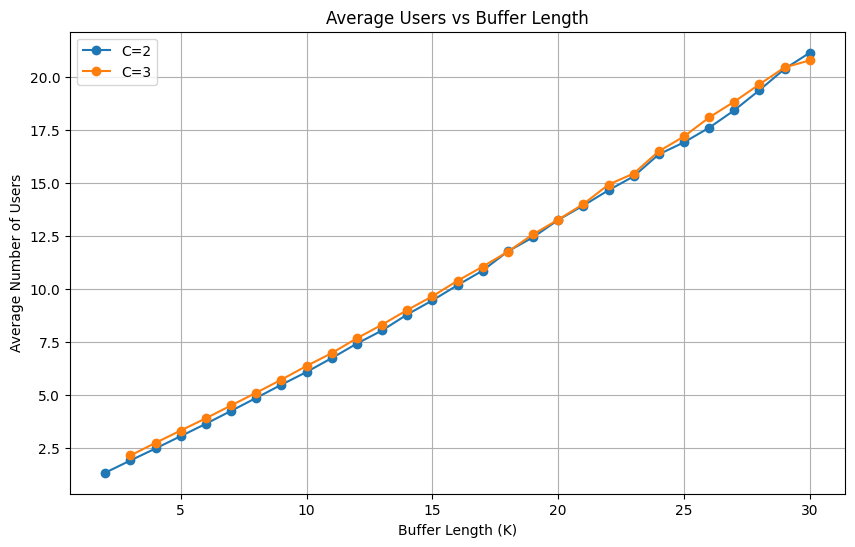

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for c in avg_users_mean["C"].unique():
    mask = avg_users_mean["C"] == c
    plt.plot(avg_users_mean.filter(mask)["K"],
             avg_users_mean.filter(mask)["avg_users_mean"],
             label=f"C={c}",
             marker='o')

plt.xlabel("Buffer Length (K)")
plt.ylabel("Average Number of Users")
plt.title("Average Users vs Buffer Length")
plt.grid(True)
plt.legend()
plt.show()


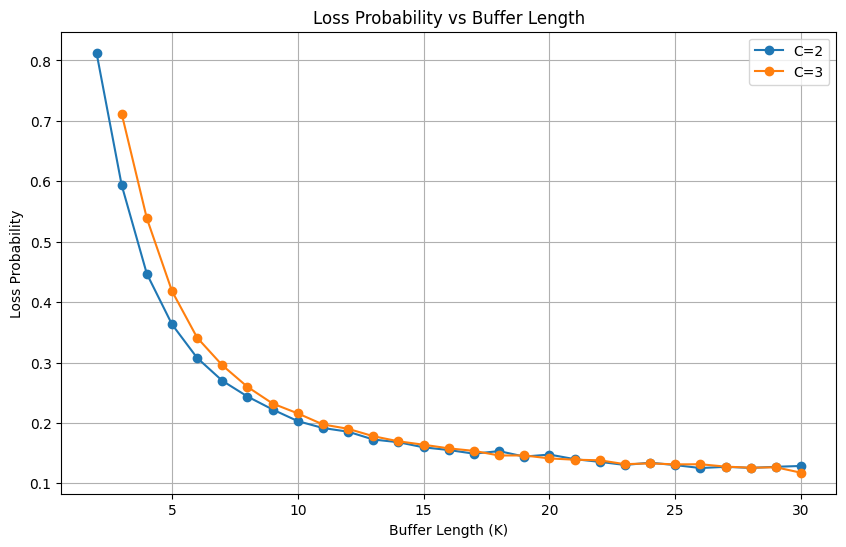

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for c in loss_prob_mean["C"].unique():
    mask = loss_prob_mean["C"] == c
    plt.plot(loss_prob_mean.filter(mask)["K"],
             loss_prob_mean.filter(mask)["loss_prob_mean"],
             label=f"C={c}",
             marker='o')

plt.xlabel("Buffer Length (K)")
plt.ylabel("Loss Probability")
plt.title("Loss Probability vs Buffer Length")
plt.grid(True)
plt.legend()
plt.show()
